# Installing & importing dependencies

In [2]:
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 12.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from nltk import word_tokenize, sent_tokenize, word_tokenize
from collections import Counter
from textblob import TextBlob
import pandas as pd
import nltk
import re


nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [37]:
data = pd.read_csv('/kaggle/input/cleaned-dataset/final_cleaned_data.csv')
data.head()

,text,text_length,label
0,basically many category best seller . replace ...,267,human
1,salt good dying car crash car crash worse car ...,417,human
2,way work old tv station got certain amount ban...,482,human
3,ca go around assassinating leader country nt l...,201,human
4,wanting kill shit german drive innovation . fr...,287,human


# Feature engineering

## Addional Features


### Defining functions

In [38]:
def avg_word_length(text):
    """
    calculates the average word length in a given text.
    """
    words = word_tokenize(text)
    return sum(len(word) for word in words) / len(words)

In [39]:
def calculate_type_token_ratio(text):
    """
    calculate the type-token ratio (TTR) for lexical richness.
    """
    tokens = word_tokenize(text)
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if tokens else 0


In [40]:
def sentiment_score(text):

    if TextBlob(text).sentiment.polarity > 0:
        return 1
    elif TextBlob(text).sentiment.polarity < 0:
        return -1
    else:
        return 0

In [41]:
def average_words_in_sentences(text):
    """
    calculate the average number of words per sentence.
    """
    sentences = sent_tokenize(text)
    if not sentences:
        return 0
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    return sum(sentence_lengths) / len(sentences)


In [42]:
def count_hapax_legomena(text):
    """
    calculate number of words that are used just one time.
    """
    words = word_tokenize(text)

    word_counts = Counter(words)

    hapax_legomena = [word for word, count in word_counts.items() if count == 1]

    return len(hapax_legomena)

In [46]:
def calculate_repetition_rate(text):
    """
    calculate the repetition rate in text.
    """
    words = word_tokenize(text)

    word_counts = Counter(words)

    repeated_words = sum(1 for count in word_counts.values() if count > 1)

    total_words = len(words)

    if total_words == 0:
        return 0

    repetition_rate = repeated_words / total_words

    return repetition_rate


### Applying Functions to text column to extract new features

In [ ]:
from joblib import Parallel, delayed
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter

def compute_features(text):
    return {
        'avg_word_length': avg_word_length(text),
        'type_token_ratio': calculate_type_token_ratio(text),
        'sentiment_score': sentiment_score(text),
        'avg_words_in_sentences': average_words_in_sentences(text),
        'hapax_legomena': count_hapax_legomena(text),
        'repetition_rate': calculate_repetition_rate(text),
    }

features = Parallel(n_jobs=-1, verbose=1)(
    delayed(compute_features)(text) for text in data['text']
)
features_df = pd.DataFrame(features)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


In [ ]:
null_summary = features_df.isnull().sum()
print("Null values per column:")
print(null_summary)
features_df.head()

### Concatinating existing features with the added

In [ ]:
data = pd.concat([data, features_df], axis=1)

#dropping text_length
data.drop('text_length', axis=1, inplace=True)

data.rename(columns={"label": "label_target"}, inplace=True)

data.head()

## Tf-Idf Vectorizer

In [4]:
data = pd.read_csv('/kaggle/input/data-with-added-features/final_data.csv')

In [5]:
data["label_target"] = data["label_target"].map({"human": 0, "Ai": 1})
data.tail()

,text,label_target,avg_word_length,type_token_ratio,sentiment_score,avg_words_in_sentences,hapax_legomena,repetition_rate
89608,work demonstrate potential benefit combining t...,1,7.028777,0.726619,-1,17.375,84,0.122302
89609,work investigate constraint modified gravity m...,1,6.925000,0.733333,1,15.000,72,0.133333
89610,investigation parity violation hydrogen topic ...,1,7.041667,0.700000,1,12.000,67,0.141667
89611,study explore multifractal scaleinvariant aspe...,1,7.731343,0.731343,1,16.750,79,0.141791
89612,work aim develop framework computing higher th...,1,6.535948,0.607843,1,15.300,75,0.117647


### correlation study

label_target              1.000000
repetition_rate           0.339802
avg_word_length           0.243065
avg_words_in_sentences    0.087156
sentiment_score           0.047733
hapax_legomena           -0.288098
type_token_ratio         -0.442966
Name: label_target, dtype: float64


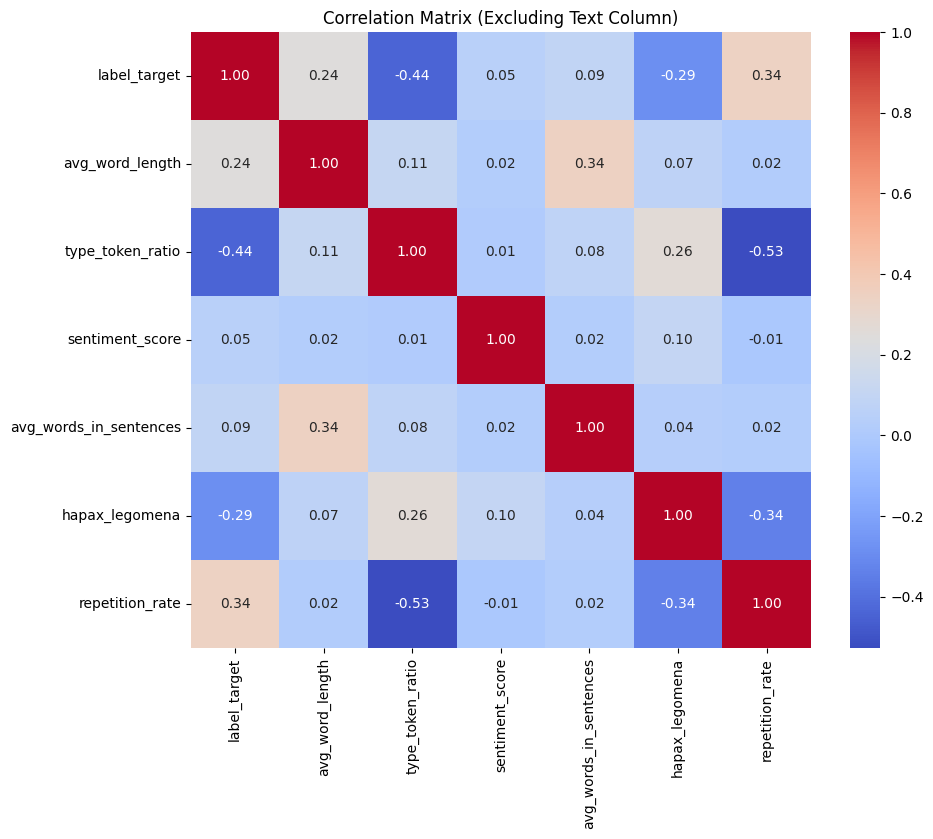

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_no_text = data[[col for col in data.columns if col != "text"]]

correlations = data_no_text.corr()

correlations_with_label = correlations['label_target'].sort_values(ascending=False)
print(correlations_with_label)

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Excluding Text Column)")
plt.show()

In [7]:
data = data.drop(columns=['avg_words_in_sentences', 'sentiment_score'], axis=1)

data.head()

,text,label_target,avg_word_length,type_token_ratio,hapax_legomena,repetition_rate
0,basically many category best seller . replace ...,0,4.869231,0.523077,43,0.192308
1,salt good dying car crash car crash worse car ...,0,5.213270,0.644550,106,0.142180
2,way work old tv station got certain amount ban...,0,5.389764,0.527559,93,0.161417
3,ca go around assassinating leader country nt l...,0,5.411765,0.774510,66,0.127451
4,wanting kill shit german drive innovation . fr...,0,5.851064,0.751773,86,0.141844


### vectorizing

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

text_data = data['text']
numeric_features = data[['repetition_rate', 'avg_word_length', 'type_token_ratio','hapax_legomena','label_target']]

tfidf_vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
tfidf_features = tfidf_vectorizer.fit_transform(text_data)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_feature_names)

combined_df = pd.concat([tfidf_df, numeric_features.reset_index(drop=True)], axis=1)

data = combined_df

In [9]:
data.head()

,aa,aaron,ab,abandoned,abc,abdomen,abdominal,abdominal pain,ability,ability make,...,zipper,zombie,zone,zoo,zoom,repetition_rate,avg_word_length,type_token_ratio,hapax_legomena,label_target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.192308,4.869231,0.523077,43,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.142180,5.213270,0.644550,106,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.161417,5.389764,0.527559,93,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.127451,5.411765,0.774510,66,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.141844,5.851064,0.751773,86,0


### Normalization of features

In [10]:
y = data['label_target']
X = data.drop(columns=['label_target'])

data_back = data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

data_back[X.columns] = X_normalized

data_back.head()

,aa,aaron,ab,abandoned,abc,abdomen,abdominal,abdominal pain,ability,ability make,...,zipper,zombie,zone,zoo,zoom,repetition_rate,avg_word_length,type_token_ratio,hapax_legomena,label_target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.384615,0.171295,0.514326,0.229947,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.284360,0.188787,0.638028,0.566845,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.322835,0.197760,0.518890,0.497326,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.254902,0.198879,0.770372,0.352941,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.283688,0.221213,0.747218,0.459893,0


In [11]:
import pickle

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Model training and selection

In [12]:
from sklearn.model_selection import train_test_split

y = data_back['label_target']
X = data_back.drop(columns=['label_target'])

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print('training set size',X_train.shape)
print('training set size',y_train.shape)

training set size (71690, 15004)
training set size (71690,)


we will take a smaller dataset for the gridSearch like 10%-20% of the training set

In [13]:
from sklearn.model_selection import train_test_split
from collections import Counter


X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, test_size=0.9, random_state=42, shuffle=True)

print('training set size',X_sub_train.shape)
print('training set size',y_sub_train.shape)

class_distribution = Counter(y_sub_train)
print(f"Class Distribution in y_subset: {class_distribution}")


training set size (7169, 15004)
training set size (7169,)
Class Distribution in y_subset: Counter({1: 3599, 0: 3570})


## logistic Regression

### Grid Search

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lg_model = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1, 10, 100],
    'solver': ['saga','lbfgs'],
    'max_iter': [100, 1000],
}

lg_search = GridSearchCV(
    estimator=lg_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

lg_search.fit(X_sub_train, y_sub_train)

print("Best Parameters for Logistic Regression:", lg_search.best_params_)
print("Best Cross-Validation Score for Logistic Regression:", lg_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best Parameters for Logistic Regression: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Score for Logistic Regression: 0.9161670207418591


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Model Training

In [14]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(C=10 ,penalty='l2' ,solver='saga' ,max_iter=100 ,verbose=1 ,n_jobs=-1)
lg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.12468668
Epoch 3, change: 0.07349324
Epoch 4, change: 0.05133985
Epoch 5, change: 0.04049281
Epoch 6, change: 0.03385228
Epoch 7, change: 0.02908250
Epoch 8, change: 0.02524440
Epoch 9, change: 0.02101624
Epoch 10, change: 0.01849109
Epoch 11, change: 0.01643798
Epoch 12, change: 0.01383633
Epoch 13, change: 0.01323578
Epoch 14, change: 0.01216470
Epoch 15, change: 0.01123931
Epoch 16, change: 0.01061456
Epoch 17, change: 0.00989982
Epoch 18, change: 0.00946941
Epoch 19, change: 0.00894765
Epoch 20, change: 0.00810027
Epoch 21, change: 0.00791129
Epoch 22, change: 0.00735871
Epoch 23, change: 0.00720579
Epoch 24, change: 0.00706980
Epoch 25, change: 0.00697094
Epoch 26, change: 0.00683555
Epoch 27, change: 0.00672399
Epoch 28, change: 0.00663034
Epoch 29, change: 0.00649348
Epoch 30, change: 0.00640179
Epoch 31, change: 0.00629692
Epoch 32, change: 0.00621722
Epoch 33, change: 0.00606213
Epoch 34, change: 0.00599016
Epoch 35, change: 0.005

LogisticRegression(C=10, max_iter=500, n_jobs=-1, solver='saga', verbose=1)

### Model Evaluation

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

lg_pred = lg.predict(X_test)
accuracy = accuracy_score(y_test, lg_pred)
precision = precision_score(y_test, lg_pred)
recall = recall_score(y_test, lg_pred)

print(f"Accuracy for Logistic regression: {accuracy}")
print(f"Precision for Logistic regression: {precision}")
print(f"Recall for Logistic regression: {recall}")

Accuracy for Logistic regression: 0.9396306421915974
Precision for Logistic regression: 0.9367955801104972
Recall for Logistic regression: 0.9432576769025367


Class Names: [0 1]


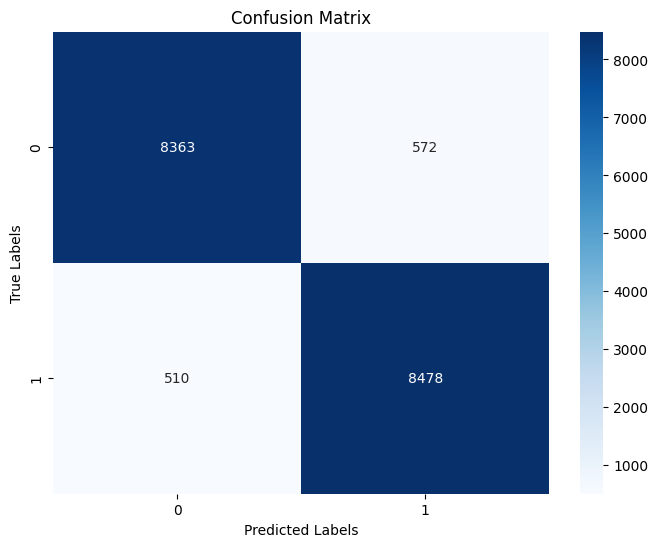

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


class_names = np.unique(y_test)
print("Class Names:", class_names)

conf_matrix = confusion_matrix(y_test, lg_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## SVM

### Grid Search

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm_model = SVC()

param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale'],
    'max_iter': [ 500, 1000],
}


svm_search = GridSearchCV(
    estimator=svm_model, 
    param_grid=param_grid,
    scoring='accuracy',
    cv=4, 
    verbose=1, 
    n_jobs=-1
)

svm_search.fit(X_sub_train, y_sub_train)

print("Best Parameters for SVM:", svm_search.best_params_)
print("Best Cross-Validation Score for SVM:", svm_search.best_score_)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-

Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 1000}
Best Cross-Validation Score for SVM: 0.9115638663004939


/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Model Training

In [15]:
from sklearn.svm import SVC

svm = SVC(gamma='scale', kernel='rbf', max_iter=1000 ,C=1)
svm.fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=1, max_iter=1000)

### Model Evaluation

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

svm_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, svm_pred)
precision = precision_score(y_test, svm_pred)
recall = recall_score(y_test, svm_pred)

print(f"Accuracy for SVM: {accuracy}")
print(f"Precision for SVM: {precision}")
print(f"Recall for SVM: {recall}")

Accuracy for SVM: 0.8652569324331864
Precision for SVM: 0.8385701040486248
Recall for SVM: 0.9056519804183356


Class Names: [0 1]


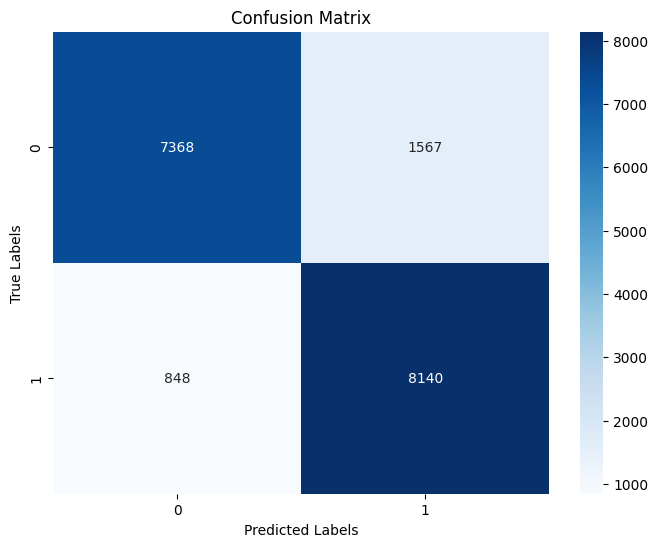

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


class_names = np.unique(y_test)
print("Class Names:", class_names)

conf_matrix = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Naive Bayese

### Grid Search

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV



mnb_model = MultinomialNB()

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

mnb_search = GridSearchCV(
    estimator=mnb_model,
    param_grid=param_grid,
    cv=4,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

mnb_search.fit(X_sub_train, y_sub_train)

print("Best Parameters:", mnb_search.best_params_)
print("Best Cross-Validation Score:", mnb_search.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best Parameters: {'alpha': 1.0, 'fit_prior': True}
Best Cross-Validation Score: 0.8568829021342921


### Model Training

In [19]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1.0, fit_prior= True)
mnb.fit(X_train, y_train)

MultinomialNB()

### Model Evaluation

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

mnb_pred = mnb.predict(X_test)
accuracy = accuracy_score(y_test, mnb_pred)
precision = precision_score(y_test, mnb_pred)
recall = recall_score(y_test, mnb_pred)

print(f"Accuracy for Multinomail NB: {accuracy}")
print(f"Precision for Multinomail NB: {precision}")
print(f"Recall for Multinomail NB: {recall}")

Accuracy for Multinomail NB: 0.8636946939686436
Precision for Multinomail NB: 0.8755882015379318
Recall for Multinomail NB: 0.8487983978638184


Class Names: [0 1]


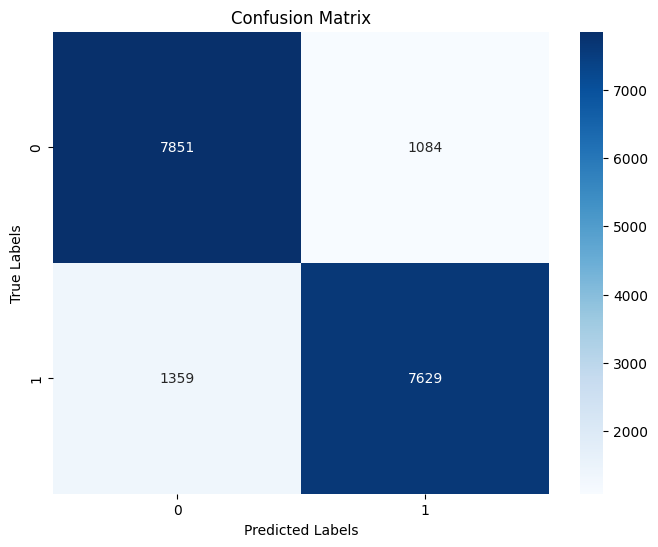

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


class_names = np.unique(y_test)
print("Class Names:", class_names)

conf_matrix = confusion_matrix(y_test, mnb_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## RandomForest

### Grid Search

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



ranf = RandomForestClassifier()

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [20, 40],
    'min_samples_split': [2, 5],
}


rnf_search = GridSearchCV(
    estimator=ranf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=1,
    n_jobs=-1
)

rnf_search.fit(X_sub_train, y_sub_train)

print("Best Parameters:", rnf_search.best_params_)
print("Best Cross-Validation Score:", rnf_search.best_score_)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Parameters: {'max_depth': 40, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Score: 0.8927312502489841


### Model Training

In [16]:
from sklearn.ensemble import RandomForestClassifier

ranf = RandomForestClassifier(n_estimators=300, min_samples_split=2, max_depth=40, n_jobs=-1, verbose=1)
ranf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.6s finished


RandomForestClassifier(max_depth=40, n_estimators=300, n_jobs=-1, verbose=1)

### Model Evaluation

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


ranf_pred = ranf.predict(X_test)
accuracy = accuracy_score(y_test, ranf_pred)
precision = precision_score(y_test, ranf_pred)
recall = recall_score(y_test, ranf_pred)

print(f"Accuracy for random forest: {accuracy}")
print(f"Precision for random forest: {precision}")
print(f"Recall for random forest: {recall}")

Accuracy for random forest: 0.9131841767561234
Precision for random forest: 0.8969237342448195
Recall for random forest: 0.9342456608811749


[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done 300 out of 300 | elapsed:    0.2s finished


Class Names: [0 1]


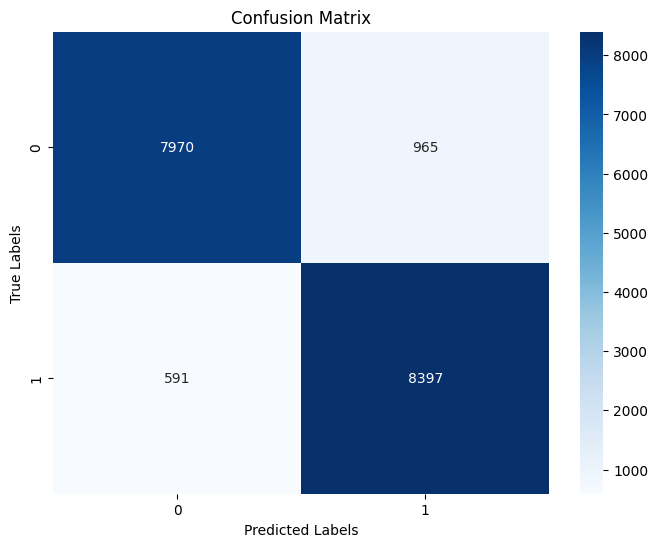

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


class_names = np.unique(y_test)
print("Class Names:", class_names)

conf_matrix = confusion_matrix(y_test, ranf_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Xgboost

In [21]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Grid Search

In [23]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss')

param_grid = {
    'n_estimators': [100, 200],    
    'max_depth': [3, 6],           
    'learning_rate': [0.1, 0.2],   
    'subsample': [0.8, 1.0],  
}

xgb_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=3,                
    verbose=1,
    n_jobs=-1         
)

xgb_search.fit(X_sub_train, y_sub_train)

print("Best parameters found: ", xgb_search.best_params_)
print("Best accuracy: ", xgb_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best accuracy:  0.9008228672442792
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time= 1.6min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100,

### Model Training

In [25]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8, n_jobs=-1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

### Model evaluation

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, xgb_pred)
precision = precision_score(y_test, xgb_pred)
recall = recall_score(y_test, xgb_pred)

print(f"Accuracy for XGB: {accuracy}")
print(f"Precision for XGB: {precision}")
print(f"Recall for XGB: {recall}")

Accuracy for XGB: 0.9374546671874128
Precision for XGB: 0.9346889159023096
Recall for XGB: 0.9410324877614598


Class Names: [0 1]


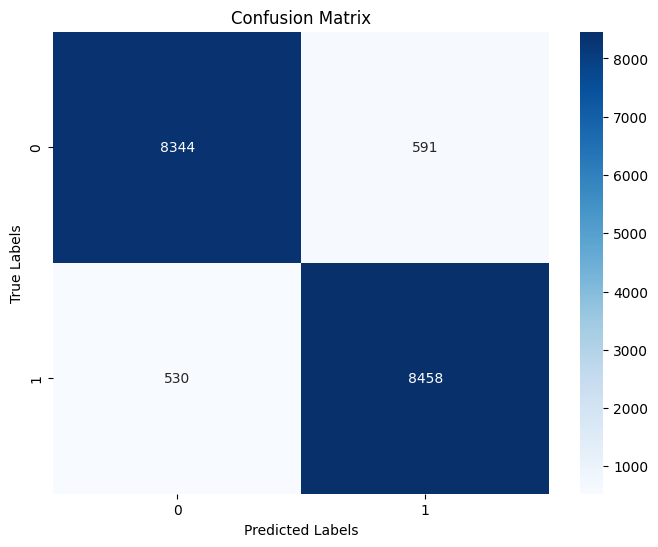

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


class_names = np.unique(y_test)
print("Class Names:", class_names)

conf_matrix = confusion_matrix(y_test, xgb_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# saving the model and vectorizer

In [44]:
import pickle

with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(lg, model_file)

with open('model_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

## 